In [1]:
# 必要なライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import os
import re
import glob
import shutil
import gc
import pyarrow as pa
import dask as da
import dask.dataframe as dd
from pathlib import Path

# matplotlibの日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format

# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14

# グラフの表示方法調整
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

# 乱数の種
random_seed = 123

<Figure size 864x360 with 0 Axes>

In [2]:
# タイマー
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

## 機械学習とは
機械学習とは、ざっと言ってしまうとあるデータ X を入力として対応する予測値 y を取り出すような対応関係を作成することです。

例：タイタニック号で、乗客が生きるか死ぬかを予測する問題だと X は乗客の年齢, 性別, 船室のグレード… など乗客に紐づく情報のことを指します。通常、この情報のことを特徴量とよびます。

特徴量 X と 予測値 y が用意できれば学習用データ (X - y の関係がわかっているデータ) を元にして X をいれて y になるようにモデルを調整する。この調整の段階を学習とよびます。学習には様々なアルゴリズムがあるが、X, y を用意しなくてはならない部分は基本的に変わらないです。

# 今回のコンペに関して

コンペ自体のデータサイズが大きいのでデータハンドリングが僕たちに取っては肝になりそうです（この辺をよく知っている人教えてください！）

### データの読み込みに関して
* 形式を変えたデータセットをpandasで読み込む
  * [`feather`形式](https://www.kaggle.com/datasets/munumbutt/amexfeather) or [`Parquet`形式](https://www.kaggle.com/datasets/odins0n/amex-parquet)
* [`pyspark`](https://www.kaggle.com/code/rakkaalhazimi/export-large-dataset-to-spark) or [`dask`](https://docs.dask.org/en/latest/dataframe.html) で読み込む

### サイズが大きい場合の対処方法は以下のkaggle notebookを参考にしてみてください

[> How to Work with BIG Datasets on 16G RAM (+Dask)](https://www.kaggle.com/code/yuliagm/how-to-work-with-big-datasets-on-16g-ram-dask)

上記notebookの内容概要
* TIP 1 - 使用していない変数を [`delete`](https://www.sejuku.net/blog/74447) するか & gc.collect()` で[ガベージコレクション](https://techacademy.jp/magazine/19437)(不要になったメモリ領域を開放して再利用する機能)をする
* TIP 2 - データセット内の各カラムのデータタイプを予め定義しておく
  * eg: 本来 float64 だったものを -> float32 と定義してサイズを圧縮する
* TIP 3 - 読み込むデータセットを選択する (including generating your own subsamples)
  * 読み込む行数を選ぶ
  * (`skiprows`) で[読み飛ばす行数を指定する](https://bit.ly/3O90Ze7)
  * 読み飛ばすリストを作成して、読み飛ばす（以下例）
    * ```
      skiplines = np.random.choice(np.arange(1, lines), size=lines-1-1000000, replace=False)
      skiplines=np.sort(skiplines)
      train = pd.read_csv('../input/train.csv', skiprows=skiplines, dtype=dtypes)
      ```
* TIP 4 - バッチ処理をする
  * ひとまとまりのデータに対して、一連の処理を連続で実行する処理方式のこと。大きなデータに関しても、設定したデータ数(チャンク)ごとに処理をする
* TIP 5 - 特定のカラムのみ `import` する
  * 450,000行 × 150カラム より 100万行 × 2カラム の方がメモリ消費が少ないことは容易に想像できる
* TIP 6 - groupby などの処理をするときも一部カラムの一部データのみにするˆ
* TIP 7 - `Dask` を使用する。
  * [DaskについてのQiita記事](https://qiita.com/simonritchie/items/e174f243bc03fb25462e)

## コンペの概要
* コンペ名：[American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction)

* 目的：毎月の顧客プロファイルから、顧客がクレジットカードの残高分を将来返済しない確率を予測すること
  * ターゲットのバイナリ変数は、最新のクレジットカード明細書から18ヶ月間のパフォーマンスウィンドウを観察することによって計算され、顧客が最新の明細書の日付から120日以内に支払額を支払わない場合、デフォルトとみなされる。

* 評価方法(Evaluation)
  * このコンペではクレカのデフォルト率を予測する。サブミットはちょっと特殊な評価方法で評価される。以下の通り:
    * ```
      M = 0.5*(G+D)  (*G = 正規化ジニ係数, D = デフォルト率 4% )
      ```
      機械学習における `正規化ジニ係数` は経済学などで使用される ジニ係数とは違うので注意です。以下記事を参照にしてみてください
      * [機械学習のモデル評価、説明可能性のための指標　その１。ジニ係数とAUC](https://qiita.com/Derek/items/4ded249f7a75f8da176c)
      * [DataRobot](https://docs.datarobot.com/ja/docs/modeling/reference/model-detail/opt-metric.html#gini-coefficient)
      * [GINI and AUC relationship](https://stats.stackexchange.com/questions/342329/gini-and-auc-relationship)
      * [Why use Normalized Gini Score instead of AUC as evaluation?](https://stats.stackexchange.com/questions/306287/why-use-normalized-gini-score-instead-of-auc-as-evaluation)

# データ管理環境整備

≒ディレクトリ整備

In [3]:
# # input_dir（input directory） を作る
current_note_path = os.path.dirname(os.path.abspath('__file__'))
INPUT_DIR = os.path.join(current_note_path, "data")

# INPUT_DIRがまだ作られていなければ作成
if not os.path.isdir(INPUT_DIR):
    os.mkdir(INPUT_DIR)

# output_dir(output directory) を作る
OUTPUT_DIR = os.path.join(current_note_path, 'outputs')

# OUTPUT_DIRがまだ作られていなければ作成
if not os.path.isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [4]:
# 一度やったらコメントアウトする

# # csvファイルを `data` ディレクトリ（=フォルダー） に移動させる
# unique_dir_names = []
# for f in Path(f'{current_note_path}').rglob('*.csv'):
#     unique_dir_names.append(f)

# for file in list(set(unique_dir_names)):
#     print(f'moved file: {file}')
#     shutil.move(f'{file}', f'{INPUT_DIR}')

In [5]:
# csv(or any file)を簡単に読み込めるようにする関数
# csv を読み取る関数を設定したあげると、pathや拡張子を書かずに読み込めるので入力が楽になります

# 通常のcsvファイルを読み取るときは以下
def read_csv(name, **kwrgs):
    path = os.path.join(INPUT_DIR, name + '.csv')
    print(f'Load: {path}')
    return pd.read_csv(path, **kwrgs)

# （一番速い）今回はparquet形式を dask モジュールで読み込むため別途用意
def read_parquet(name, **kwrgs):
    path = os.path.join(INPUT_DIR, name + '.parquet')
    print(f'Load: {path}')
    return pd.read_parquet(path, **kwrgs)

# データ読み込み

前記の通り、データサイズが大きく、安易に `pandas` などを使ってもローカルではメモリが足りないので、ここではcsv形式を `parquet` 形式に変えてimport します

(*本来は自分でcsv -> parquet形式に変える必要がありますが、心優しい人がparquet形式にしてくれているのでそれを参照します。)
* [該当データダウンロードページ](https://www.kaggle.com/datasets/odins0n/amex-parquet)
* [Load Parquet Files with Low Memory](https://www.kaggle.com/code/odins0n/load-parquet-files-with-low-memory)
* [parquetデータを使用したEDA](https://www.kaggle.com/code/odins0n/amex-default-prediction-detailed-eda)

In [6]:
# parquet データを import
test = read_parquet('test_data2')
train = read_parquet('train_data')
train_labels = read_csv('train_labels')
sample_sub = read_csv('sample_submission')

Load: /Users/satoshiido/Documents/coding_general/kaggle/amex-default-prediction/data/test_data2.parquet
Load: /Users/satoshiido/Documents/coding_general/kaggle/amex-default-prediction/data/train_data.parquet
Load: /Users/satoshiido/Documents/coding_general/kaggle/amex-default-prediction/data/train_labels.csv
Load: /Users/satoshiido/Documents/coding_general/kaggle/amex-default-prediction/data/sample_submission.csv


In [120]:
# ガベージコレクション
gc.collect()

0

In [19]:
# 以下のカラムは頻出と考えられ、毎回入力するのはめんどくさいので、ポップアップされるように定義します
customer_ID = 'customer_ID'
TARGET = 'target'

# 各テーブルの概説

* データについて
  * データセットには各顧客の特徴が各明細書日付ごとに集約されたものが含まれている。特徴は匿名化され、正規化されており、以下のカテゴリに分類されている（カラムの prefix を見ると分かる）:
    * D_*: Delinquency variables
    * S_*: Spend variables
    * P_*: Payment variables
    * B_*: Balance variables
    * R_*: Risk variables
  * 以下のカラムはカテゴリ変数である:
    * B_30, B_38, D_63, D_64, D_66, D_68, D_114, D_116, D_117, D_120, D_126

# EDA (データ確認)

> これ以降のデータハンドリングは Dask packageを使おうと思います（僕もまだ勉強中です）

この辺の記事を読んでなんとなく理解してみてください！
* [PythonのDaskをしっかり調べてみた（大きなデータセットを快適に扱う）](https://qiita.com/simonritchie/items/e174f243bc03fb25462e)

> EDA はこの辺もまずは参考にしてみてもいいと思います
* [AMEX EDA (Comparison of training and test data)](https://www.kaggle.com/code/onodera1/amex-eda-comparison-of-training-and-test-data)

## train data

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: float32(185), int64(2), object(4)
memory usage: 4.1+ GB


In [26]:
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.9385,0.0017,0.0087,1.0068,0.0092,0.1240,0.0088,0.0047,NaN,NaN,0.0006,0.0810,0.7089,0.1706,0.0062,0.3586,0.5254,0.2557,NaN,0.0639,0.0594,0.0065,0.1487,1.3359,0.0082,0.0014,0.2073,0.7365,0.0962,NaN,0.0234,0.0028,0.0083,1.0015,0.0083,0.1613,0.1483,0.9230,0.3546,0.1520,0.1181,0.0019,0.1586,0.0657,0.0184,0.0636,0.1996,0.3082,0.0164,0.4016,0.0911,CR,O,0.0071,0.0077,NaN,0.6530,0.0085,NaN,0.0047,6.0000,0.2720,0.0084,0.5152,0.0026,0.0090,0.0048,0.0083,0.1194,0.0048,0.1083,0.0509,NaN,0.0076,0.0804,0.0691,NaN,0.0043,0.0076,NaN,0.0077,0.0003,0.0016,0.0042,0.0014,NaN,0.0023,0.0041,0.0071,0.0025,0.0023,0.0035,0.5066,0.0080,1.0098,0.0847,0.0038,0.0070,0.0004,0.0065,0.0008,0.0051,NaN,0.0000,0.0057,0.0071,NaN,0.0002,0.0089,NaN,1,0.0025,0.0052,0.0066,0.0097,0.0078,0.0024,1.0011,0.0027,0.0075,0.0069,1.5037,1.0061,0.0036,0.0089,0.0039,0.0036,0.0050,0.8941,0.1356,0.9112,0.9745,0.0012,0.7667,1.0087,1.0046,0.8937,NaN,0.6700,0.0100,0.0046,NaN,1.0089,2.0000,NaN,0.0043,NaN,NaN,NaN,1.0073,0.2101,0.6769,0.0079,1.0000,0.2383,0.0000,4.0000,0.2321,0.2363,0.0000,0.7023,0.4343,0.0031,0.6865,0.0087,1.0000,1.0033,1.0078,1.0001,0.0068,NaN,0.0021,0.0060,NaN,0.0043,0.0015,NaN,NaN,NaN,NaN,NaN,0.0024,0.0037,0.0038,NaN,0.0006,0.0006,0.0027,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.9367,0.0058,0.0049,1.0007,0.0062,0.1267,0.0008,0.0027,NaN,NaN,0.0025,0.0694,0.7128,0.1132,0.0062,0.3536,0.5213,0.2233,NaN,0.0653,0.0577,0.0016,0.1497,1.3398,0.0084,0.0020,0.2028,0.7209,0.0998,NaN,0.0306,0.0027,0.0025,1.0090,0.0051,0.1410,0.1435,0.9194,0.3268,0.1562,0.1187,0.0016,0.1485,0.0939,0.0130,0.0655,0.1514,0.2650,0.0177,0.4063,0.0868,CR,O,0.0024,0.0071,NaN,0.6471,0.0022,NaN,0.0039,6.0000,0.1890,0.0040,0.5090,0.0042,0.0078,0.0013,0.0065,0.1406,0.0001,0.1010,0.0405,NaN,0.0048,0.0814,0.0742,NaN,0.0042,0.0053,NaN,0.0019,0.0010,0.0099,0.0076,0.0005,NaN,0.0098,0.0001,0.0060,0.0004,0.0013,0.0078,0.5009,0.0008,1.0095,0.0818,0.0003,0.0078,0.0043,0.0023,0.0095,0.0038,NaN,0.0000,0.0076,0.0067,NaN,0.0011,0.0059,NaN,1,0.0084,0.0090,0.0019,0.0099,0.0060,0.0022,1.0068,0.0025,0.0068,0.0028,1.5036,1.0058,0.0006,0.0004,0.0084,0.0088,0.0032,0.9021,0.1363,0.9199,0.9756,0.0046,0.7860,1.0001,1.0041,0.9068,NaN,0.6686,0.0039,0.0047,NaN,1.0032,2.0000,NaN,0.0087,NaN,NaN,NaN,1.0077,0.1841,0.8223,0.0034,1.0000,0.2472,0.0000,4.0000,0.2435,0.2419,0.0000,0.7070,0.4305,0.0013,0.6864,0.0008,1.0000,1.0084,1.0043,1.0083,0.0044,NaN,0.0010,0.0048,NaN,0.0075,0.0049,NaN,NaN,NaN,NaN,NaN,0.0040,0.0032,0.0050,NaN,0.0096,0.0055,0.0092,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.9542,0.0915,0.0217,1.0097,0.0068,0.1240,0.0076,0.0094,NaN,NaN,0.0076,0.0688,0.7209,0.0605,0.0033,0.3347,0.5246,0.1894,NaN,0.0670,0.0566,0.0051,0.1520,1.3372,0.0094,0.0074,0.2066,0.7380,0.1341,NaN,0.0484,0.0101,0.0005,1.0092,0.0070,0.1122,0.1370,1.0020,0.3041,0.1538,0.1145,0.0063,0.1395,0.0848,0.0567,0.0706,0.3059,0.2122,0.0640,0.4068,0.0940,CR,O,0.0019,0.0036,NaN,0.6458,0.0004,Na

In [28]:
print("train データの一番古い日時 {} ; train データ一番新しい日時 {}.".format(train['S_2'].min(),train['S_2'].max()))
print("train データ内数 {:,.0f} ; カラム数 {}".format(len(train),len(train.columns)))

train データの一番古い日時 2017-03-01 ; train データ一番新しい日時 2018-03-31.
train データ内数 5,531,451 ; カラム数 191


In [29]:
# カラム名をわかりやすくする
titles=['Delinquency '+str(i).split('_')[1] if i.startswith('D') 
        else 'Spend '+str(i).split('_')[1] if i.startswith('S') 
        else 'Payment '+str(i).split('_')[1] if i.startswith('P') 
        else 'Balance '+str(i).split('_')[1] if i.startswith('B') 
        else 'Risk '+str(i).split('_')[1] if i.startswith('R')
        else customer_ID
        for i in train.columns[:-1]
        ]

In [ ]:
# train データのカラム名変更
titles.append('target')
train.columns = titles

In [37]:
# Target {0|1} 比率
train_target = pd.DataFrame(train[TARGET].value_counts()).reset_index()
train_target.columns = [TARGET, 'count']

fig = px.bar(data_frame = train_target, x=TARGET, y='count', width=600, height=400)
fig.update_traces(
                marker_color = ['#58D68D', '#DE3163'],
                marker_line_color = 'rgb(0,0,0)',
                marker_line_width=2)
fig.update_layout(
                title= 'Target 分布', 
                template = 'plotly_white',
                title_x = 0.5)

print('Target == 0 の比率: %0.2f%%' % (train_target["count"][0]*100 / (train_target["count"][0]+ train_target["count"][1])))
print('Target == 1 の比率: %0.2f%%' % (train_target["count"][1]*100 / (train_target["count"][0]+ train_target["count"][1])))

fig.show()

Target == 0 の比率: 75.09%
Target == 1 の比率: 24.91%


### 連続変数

In [50]:
# カテゴリ変数のリスト
cat_cols=['Balance 30', 'Balance 38', 'Delinquency 63', 'Delinquency 64', 'Delinquency 66', 'Delinquency 68',
          'Delinquency 114', 'Delinquency 116', 'Delinquency 117', 'Delinquency 120', 'Delinquency 126', 'category']
COLS = list(train.columns[2:190])
# リスト形式で連続変数のみ抽出する
cont_cols = [col for col in COLS if col not in cat_cols and TARGET]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


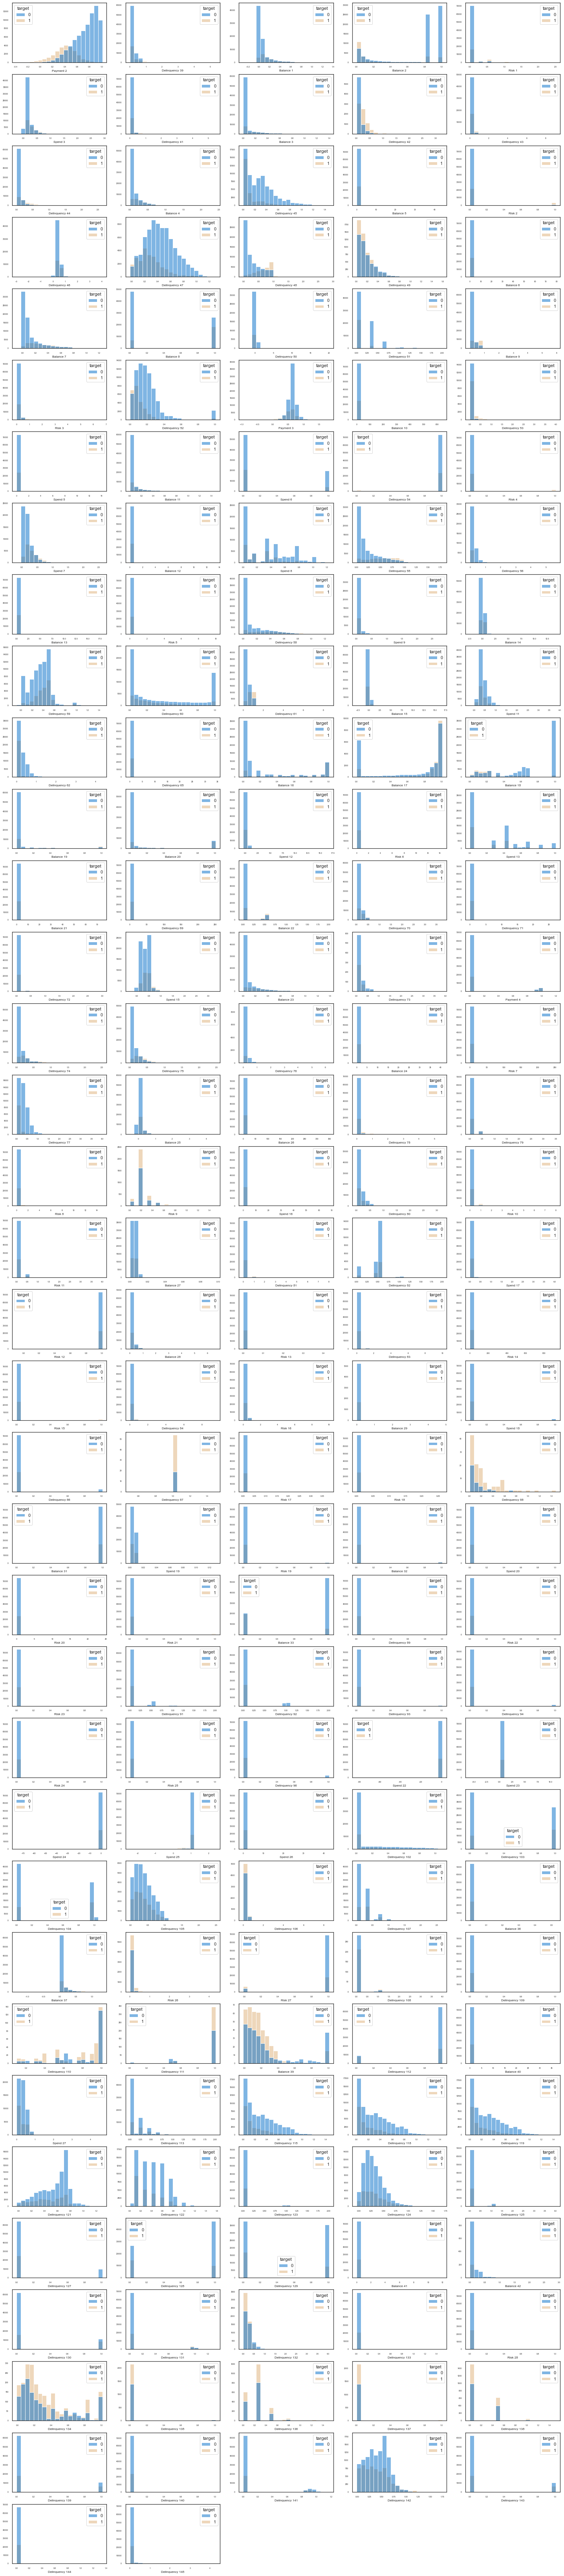

In [127]:
RANDOM_SPLIT = 100000
ncols = 5
nrows = 36
fig, axes = plt.subplots(nrows, ncols, figsize=(25, 15*8))
# パレットカラーの指定
pal = ['#016CC9','#DEB078']
plt.legend(loc='upper right')

for r in range(nrows):
    for c in range(ncols):
        if r*ncols+c == len(cont_cols):
            break
        col = cont_cols[r*ncols+c]
        sns.histplot(data= train.iloc[:RANDOM_SPLIT],  x=col, ax=axes[r, c], hue= "target", bins = 20, palette =pal)
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=8)
        axes[r, c].tick_params(labelsize=5, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(6)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
fig.delaxes(axes[35][2])
fig.delaxes(axes[35][3])   
fig.delaxes(axes[35][4])
plt.show()

### カテゴリ変数

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


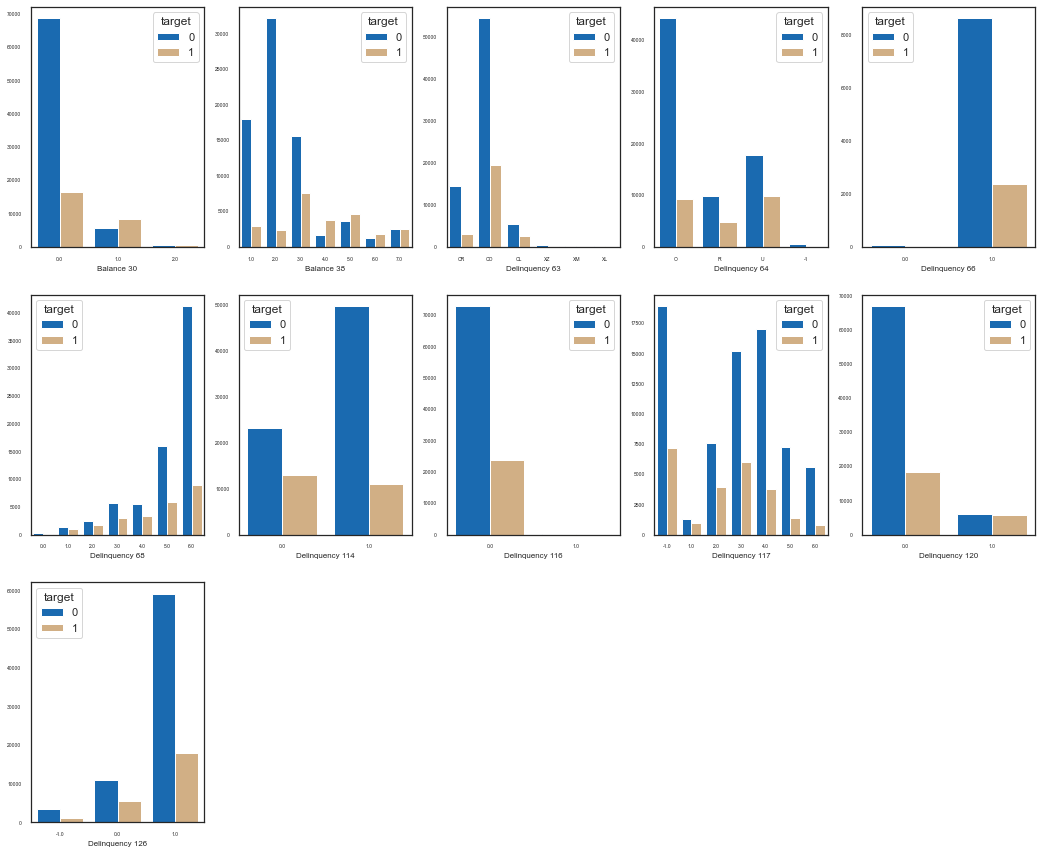

In [125]:
RANDOM_SPLIT = 100000
n_features = [col for col in cat_cols if col != 'category']
ncols = 5
nrows = int(len(n_features) / ncols + (len(COLS) % ncols > 0)) 
# パレットカラーの指定
pal = ['#016CC9','#DEB078']

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 15))
plt.legend(loc='upper right')
for r in range(nrows):
    for c in range(ncols):
        if r*ncols+c >= len(n_features):
            break
        col = n_features[r*ncols+c]
        sns.countplot(data=train.iloc[:RANDOM_SPLIT] , x = col, ax=axes[r, c], hue = "target", palette =pal)
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=8)
        axes[r, c].tick_params(labelsize=5, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(6)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
fig.delaxes(axes[2][1])     
fig.delaxes(axes[2][2]) 
fig.delaxes(axes[2][3]) 
fig.delaxes(axes[2][4]) 
plt.show()

In [ ]:
# ガベージコレクション
gc.collect()

## test data

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11363762 entries, 0 to 11363761
Columns: 190 entries, customer_ID to D_145
dtypes: float32(93), int16(10), int8(85), object(2)
memory usage: 5.2+ GB


In [13]:
test.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.6313,0,0.0107,0.8145,0.0000,0.1687,0.0000,0.0023,0.1132,NaN,0,9,0.0045,0.0095,0,NaN,0.4744,0.6265,-1,0.1746,1.2507,1.0039,NaN,0,0.0010,1,0.1190,NaN,-0.0029,NaN,0.0028,0.0044,1,1.0000,0,0.1056,0.1192,996,0.1146,NaN,NaN,0,0.2059,NaN,0.0102,-1,0.0275,0.5887,0.0105,52,0.0518,0,-1,0,0,NaN,0.5921,0,-1,0,-1,0.1905,0.0027,415,0.0100,NaN,0,-1,0.0147,0,7,1.1348,0.1789,0.9595,3,3,NaN,0.0098,0.0000,0.0029,0.0069,0.0017,0,-1,0,-1,0.0025,0,0,0,0.0046,0,1,0.0051,1.0000,0.1338,0,-1,0.0000,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.0090,0,0,0,0,0,1,0,0,0,-1,0,0,0,0,0,0,0.9811,0.1349,0.9547,0.9711,0.0066,0.0024,-1,NaN,NaN,-1,-1,0.0081,0.0080,-1,NaN,1,-1,0,NaN,-1,NaN,1.0000,0.2742,0.0043,-1,-1,NaN,-1,-1,NaN,NaN,-1,NaN,-1,-1,-1,-1,1,0,NaN,-1,0,NaN,NaN,NaN,NaN,0.0071,0,NaN,-1,-1,-1,-1,-1,0,NaN,NaN,-1,0.0083,-1
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.5870,0,0.0110,0.8108,0.0000,0.2414,0.0000,0.0091,0.1230,NaN,0,10,0.0095,0.0263,0,NaN,0.4736,0.6117,-1,0.1771,0.2342,1.0093,NaN,0,0.0055,1,0.1210,NaN,0.0312,NaN,0.0065,0.0100,1,1.0000,0,0.1606,0.1215,528,0.1841,NaN,0.0283,0,0.4033,0.0145,0.0251,-1,0.0548,0.6229,0.0217,56,0.0576,0,-1,0,0,NaN,0.5909,0,-1,0,-1,0.1902,0.0018,574,0.0081,NaN,0,0,0.0119,0,9,0.2084,0.1795,0.9617,3,3,NaN,0.0045,0.0000,NaN,0.0037,0.0055,0,0,0,-1,0.0072,0,0,0,0.0096,0,1,0.0073,1.0000,0.1446,0,-1,0.0000,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.0051,0,0,0,0,0,1,0,0,0,-1,0,0,0,0,0,0,0.9670,0.1385,0.9570,0.9750,0.0046,0.0065,0,0.0000,NaN,-1,0,0.0001,0.0155,-1,1.0077,1,-1,0,NaN,-1,NaN,1.0000,0.3536,0.2766,-1,-1,NaN,-1,-1,NaN,NaN,-1,NaN,-1,-1,-1,-1,1,0,0.0000,0,0,NaN,0.0000,0.0000,NaN,0.0072,0,NaN,-1,-1,-1,-1,0,0,0.0000,NaN,0,0.0038,0
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.6091,0,0.0164,1.0046,0.0000,0.2670,0.0000,0.0042,0.1253,NaN,0,10,0.0070,0.0600,0,NaN,0.4718,0.6222,-1,1.4171,0.1270,1.0046,NaN,0,0.0000,1,0.1131,NaN,0.0355,NaN,0.0034,0.0041,0,1.0000,0,0.2101,0.1201,528,0.2540,NaN,0.0337,0,0.3937,0.0229,0.0289,25,0.0837,0.6180,0.0393,46,0.0507,0,-1,0,0,NaN,0.5914,0,-1,0,-1,-0.0263,0.0072,711,0.0081,NaN,0,0,0.0156,0,9,0.1158,0.1824,0.9638,3,3,NaN,0.0041,0.0000,NaN,0.0024,0.0008,0,0,0,-1,0.0065,0,0,0,0.0066,0,1,0.0065,1.0000,0.1497,0,-1,0.0000,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.0026,0,0,0,0,0,1,0,0,0,-1,0,0,0,0,0,0,0.9705,0.1364,0.9641,0.9786,0.0056,0.0068,0,0.0000,NaN,-1,0,0.0010,0.0162,-1,1.0051,2,-1,0,NaN,-1,NaN,1.0000,0.3905,0.2479,-1,-1,NaN,-1,-1,NaN,NaN,-1,NaN,-1,-1,-1,-1,1,0,0.0000,0,0,NaN,0.0000,0.0000,NaN,0.0084,0,NaN,-1,-1,-1,-1,0,0,0.0000,NaN,0,0.0022,0
3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-05-20,0.6149,0,0.0217,0.8165,0.0000,0.1889,0.0000,0.0153,0.1234,NaN,0,11,0.0089,0.0034,0,NaN,0.4759,0.6156,-1,0.0446,0.1446,1.0091,NaN,0,0.0072,1,0.1203,NaN,0.0432,NaN,0.0072,0.0133,0,1.0000,0,0.1937,0.0733,528,0.3057,NaN,0.0408,0,0.4163,0.0194,0.0262,24,0.0632,0.6141,0.0255,30,0.0154,0,-1,0,0,NaN,0.5910,0,-1,0,-1,0.0968,0.0040,711,0.0091,NaN,0,0,0.0087,0,8,0.1319,0.1859,0.9586

In [26]:
print("test データの一番古い日時 {} ; testデータ一番新しい日時 {}".format(test['S_2'].min(),test['S_2'].max()))
print("test データ数 {:,.0f} ; カラム数 {}".format(test.shape[0],test.shape[1]))

test データの一番古い日時 2018-04-01 ; testデータ一番新しい日時 2019-10-31
test データ数 11,363,762 ; カラム数 190


In [ ]:
# test データのカラム名変更
test.columns = titles

## train vs test data

In [107]:
x = train.iloc[:10000, :]
x.groupby(customer_ID).tail(2).set_index(customer_ID, drop=True).sort_index()
x.head()

,customer_ID,Spend 2,Payment 2,Delinquency 39,Balance 1,Balance 2,Risk 1,Spend 3,Delinquency 41,Balance 3,Delinquency 42,Delinquency 43,Delinquency 44,Balance 4,Delinquency 45,Balance 5,Risk 2,Delinquency 46,Delinquency 47,Delinquency 48,Delinquency 49,Balance 6,Balance 7,Balance 8,Delinquency 50,Delinquency 51,Balance 9,Risk 3,Delinquency 52,Payment 3,Balance 10,Delinquency 53,Spend 5,Balance 11,Spend 6,Delinquency 54,Risk 4,Spend 7,Balance 12,Spend 8,Delinquency 55,Delinquency 56,Balance 13,Risk 5,Delinquency 58,Spend 9,Balance 14,Delinquency 59,Delinquency 60,Delinquency 61,Balance 15,Spend 11,Delinquency 62,Delinquency 63,Delinquency 64,Delinquency 65,Balance 16,Balance 17,Balance 18,Balance 19,Delinquency 66,Balance 20,Delinquency 68,Spend 12,Risk 6,Spend 13,Balance 21,Delinquency 69,Balance 22,Delinquency 70,Delinquency 71,Delinquency 72,Spend 15,Balance 23,Delinquency 73,Payment 4,Delinquency 74,Delinquency 75,Delinquency 76,Balance 24,Risk 7,Delinquency 77,Balance 25,Balance 26,Delinquency 78,Delinquency 79,Risk 8,Risk 9,Spend 16,Delinquency 80,Risk 10,Risk 11,Balance 27,Delinquency 81,Delinquency 82,Spend 17,Risk 12,Balance 28,Risk 13,Delinquency 83,Risk 14,Risk 15,Delinquency 84,Risk 16,Balance 29,Balance 30,Spend 18,Delinquency 86,Delinquency 87,Risk 17,Risk 18,Delinquency 88,Balance 31,Spend 19,Risk 19,Balance 32,Spend 20,Risk 20,Risk 21,Balance 33,Delinquency 89,Risk 22,Risk 23,Delinquency 91,Delinquency 92,Delinquency 93,Delinquency 94,Risk 24,Risk 25,Delinquency 96,Spend 22,Spend 23,Spend 24,Spend 25,Spend 26,Delinquency 102,Delinquency 103,Delinquency 104,Delinquency 105,Delinquency 106,Delinquency 107,Balance 36,Balance 37,Risk 26,Risk 27,Balance 38,Delinquency 108,Delinquency 109,Delinquency 110,Delinquency 111,Balance 39,Delinquency 112,Balance 40,Spend 27,Delinquency 113,Delinquency 114,Delinquency 115,Delinquency 116,Delinquency 117,Delinquency 118,Delinquency 119,Delinquency 120,Delinquency 121,Delinquency 122,Delinquency 123,Delinquency 124,Delinquency 125,Delinquency 126,Delinquency 127,Delinquency 128,Delinquency 129,Balance 41,Balance 42,Delinquency 130,Delinquency 131,Delinquency 132,Delinquency 133,Risk 28,Delinquency 134,Delinquency 135,Delinquency 136,Delinquency 137,Delinquency 138,Delinquency 139,Delinquency 140,Delinquency 141,Delinquency 142,Delinquency 143,Delinquency 144,Delinquency 145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.9385,0.0017,0.0087,1.0068,0.0092,0.1240,0.0088,0.0047,NaN,NaN,0.0006,0.0810,0.7089,0.1706,0.0062,0.3586,0.5254,0.2557,NaN,0.0639,0.0594,0.0065,0.1487,1.3359,0.0082,0.0014,0.2073,0.7365,0.0962,NaN,0.0234,0.0028,0.0083,1.0015,0.0083,0.1613,0.1483,0.9230,0.3546,0.1520,0.1181,0.0019,0.1586,0.0657,0.0184,0.0636,0.1996,0.3082,0.0164,0.4016,0.0911,CR,O,0.0071,0.0077,NaN,0.6530,0.0085,NaN,0.0047,6.0000,0.2720,0.0084,0.5152,0.0026,0.0090,0.0048,0.0083,0.1194,0.0048,0.1083,0.0509,NaN,0.0076,0.0804,0.0691,NaN,0.0043,0.0076,NaN,0.0077,0.0003,0.0016,0.0042,0.0014,NaN,0.0023,0.0041,0.0071,0.0025,0.0023,0.0035,0.5066,0.0080,1.0098,0.0847,0.0038,0.0070,0.0004,0.0065,0.0008,0.0051,NaN,0.0000,0.0057,0.0071,NaN,0.0002,0.0089,NaN,1,0.0025,0.0052,0.0066,0.0097,0.0078,0.0024,1.0011,0.0027,0.0075,0.0069,1.5037,1.0061,0.0036,0.0089,0.0039,0.0036,0.0050,0.8941,0.1356,0.9112,0.9745,0.0012,0.7667,1.0087,1.0046,0.8937,NaN,0.6700,0.0100,0.0046,NaN,1.0089,2.0000,NaN,0.0043,NaN,NaN,NaN,1.0073,0.2101,0.6769,0.0079,1.0000,0.2383,0.0000,4.0000,0.2321,0.2363,0.0000,0.7023,0.4343,0.0031,0.6865,0.0087,1.0000,1.0033,1.0078,1.0001,0.0068,NaN,0.0021,0.0060,NaN,0.0043,0.0015,NaN,NaN,NaN,NaN,NaN,0.0024,0.0037,0.0038,NaN,0.0006,0.0006,0.0027,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.9367,0.0058,0.0049,1.0007,0.0062,0.1267,0.0008,0.0027,NaN,NaN,0.0025,0.0694,0.7128,0.1132,0.0062,0.3536,0.5213,0.2233,NaN,0.0653,0.0577,0.0016,0.1497,1.3398,0.0084,0.0020,0.2028,0.7209,0.0998,NaN,0.0306,0.0027,0.0025,1.0090,0.0051,0.1410,0.1435,0.9194,0.3268,0.1562,0.1187,0.001

In [109]:
# train データに関して、各IDごと2レコードのみにする
train1 = train.groupby(customer_ID).tail(2).set_index(customer_ID, drop=True).sort_index()

In [110]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912706 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Columns: 190 entries, Spend 2 to target
dtypes: float32(185), int64(2), object(3)
memory usage: 685.9+ MB


In [117]:
# 1000万個以上あったので各IDごと2レコードのみにする
test1 = test.groupby(customer_ID).tail(2).set_index(customer_ID, drop=True).sort_index()

In [118]:
test1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1843415 entries, 00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7 to fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61cceb803ea8ec37634d
Columns: 189 entries, Spend 2 to Delinquency 145
dtypes: float32(93), int16(10), int8(85), object(1)
memory usage: 866.7+ MB


### Delinquency

In [ ]:
train_tmp1 = train.iloc[:1000000, :]
train_tmp2 = train.iloc[1000000:2000000, :]
train_tmp3 = train.iloc[2000000:3000000, :]
train_tmp4 = train.iloc[3000000:4000000, :]
train_tmp5 = train.iloc[4000000:5531451, :]

In [158]:
# train データのコピーを作成
train_tmp = train.copy()

In [132]:
# サンプルデータを抽出する
train_samp1 = train_tmp.sample(frac=0.2, random_state=1)
train_tmp = train_tmp.drop(train_samp1.index)

In [164]:
for i in range(1,2):
    f'train_sample{i}'.index

<built-in method index of str object at 0x2f60ad1f0>


In [177]:
train_tmp.drop(index=train_samp1.index, axis=1)
train_tmp.iloc[332490:332493,:]

: 

: 

In [173]:
train_samp1.index

Int64Index([ 262400, 1600043, 3224018, 2337062, 1771130,  406694, 1008077,
            2647081, 3182632, 2320515,
            ...
             101979,  332491, 2476461, 3512401, 5413593, 2850379,  101583,
            3213481, 1621439, 5136384],
           dtype='int64', length=1106290)

In [170]:
# サンプルデータを抽出する
for i in range(1,6):
    exec(f"train_samp{i} = train_tmp.sample(frac=0.2, random_state={i})")
    train_tmp = train_tmp.drop(index = f'train_samp{i}.index', axis=1)

KeyError: "['train_samp1.index'] not found in axis"

In [169]:
gc.collect()

1977

In [ ]:
# パレットカラーの指定
pal = ['#016CC9','#DEB078']

cols=[col for col in train.columns if (col.startswith(('D', 'T', 'c'))) & (col not in cat_cols[:-1])]

cols=[col for col in train.columns if (col.startswith(('D','T','c'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(18,5, figsize=(16,54))
fig.suptitle('Distribution of Delinquency Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*18
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='category', palette=pal[::-1], hue_order=[0,1], 
                label=['train','test'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(2,5):
    ax[17,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['train','test'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.983))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

In [13]:
train_labels.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [14]:
# 予測するID数は 458193 個らしい
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_ID  458913 non-null  object
 1   target       458913 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ MB


In [ ]:
# プロットするために train データにcategory列を追加し、日付データを削除
train_tmp1 = train_tmp1.assign(category=0)
train_tmp1.pop('Spend 2')

# test データにもcategory列を追加し、日付データを削除し、null値が入ったtargetを入れる
test_tmp1 = test1.assign(category=1)
test_tmp.pop('Spend 2')
test_tmp = test_tmp.assign(target='')

In [ ]:
cat_cols = ['B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126']

In [36]:

del test1['S_2']
gc.collect()


titles=['Delinquency '+str(i).split('_')[1] if i.startswith('D') 
        else 'Spend '+str(i).split('_')[1] if i.startswith('S') 
        else 'Payment '+str(i).split('_')[1] if i.startswith('P') 
        else 'Balance '+str(i).split('_')[1] if i.startswith('B') 
        else 'Risk '+str(i).split('_')[1] for i in train.columns[:-1]
        ]

cat_cols_converted=['Balance 30', 'Balance 38', 'Delinquency 63', 'Delinquency 64', 'Delinquency 66', 'Delinquency 68',
          'Delinquency 114', 'Delinquency 116', 'Delinquency 117', 'Delinquency 120', 'Delinquency 126', 'Target','category'
          ]

test1.columns = titles[1:]
titles.append('Target')
train.columns = titles

In [35]:
target=train.category.value_counts(normalize=True)
target

AttributeError: 'DataFrame' object has no attribute 'category'

In [ ]:
cols=[col for col in train.columns if (col.startswith(('D','T','c'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(18,5, figsize=(16,54))
fig.suptitle('Distribution of Delinquency Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*18
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='category', palette=pal[::-1], hue_order=[0,1], 
                label=['train','test'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(2,5):
    ax[17,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['train','test'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.983))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

## 基本統計量

In [34]:
train.iloc[:, :-1].describe().T.sort_index().style.background_gradient(cmap='GnBu').bar(subset=["max"], color='#F8766D').bar(subset=["mean"], color='#00BFC4')

,count,mean,std,min,25%,50%,75%,max
B_1,5531451.000000,0.122600,0.213146,-7.588799,0.008864,0.031330,0.125902,1.324060
B_10,5531451.000000,0.228768,4.796939,-0.002958,0.028991,0.110555,0.295539,4097.440918
B_11,5531451.000000,0.109335,0.209332,0.000000,0.006603,0.019451,0.101971,1.970375
B_12,5531451.000000,0.091987,0.817021,0.000000,0.010870,0.019441,0.069138,420.748993
B_13,5481932.000000,0.099693,0.554849,0.000000,0.009255,0.029314,0.089415,276.177826
B_14,5531451.000000,0.100098,0.280226,-8.469853,0.008151,0.028494,0.100320,55.011517
B_15,5524528.000000,0.051809,0.297811,-10.008048,0.003140,0.006235,0.009290,65.037430
B_16,5529435.000000,0.345507,0.404679,0.000000,0.006237,0.091739,0.756588,1.010000
B_17,2393853.000000,0.713945,0.387050,0.000000,0.480044,0.932087,1.002225,1.010000
B_18,5531451.000000,0.597930,0.365628,0.000000,0.206731,0.646633,1.003277,1.010000


## 欠損値・異常値確認

In [13]:
# 欠損値の確認関数
def missing_values_summary(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'mis_val_count', 1 : 'mis_val_percent'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('mis_val_percent', ascending=False).round(1)
    print ("カラム数：" + str(df.shape[1]) + "\n" + "欠損値のカラム数： " + str(mis_val_table_ren_columns.shape[0]))
    return mis_val_table_ren_columns

In [28]:
missing_values_summary(train.iloc[:, :-90])

カラム数：101
欠損値のカラム数： 56


,mis_val_count,mis_val_percent
D_73,5475595,99.0000
R_9,5218918,94.3000
D_49,4985917,90.1000
D_76,4908954,88.7000
D_66,4908097,88.7000
D_42,4740137,85.7000
D_53,4084585,73.8000
D_82,4058614,73.4000
D_50,3142402,56.8000
B_17,3137598,56.7000


In [32]:
missing_values_summary(train.iloc[:, -90:]).head(30)

カラム数：90
欠損値のカラム数： 66


,mis_val_count,mis_val_percent
D_87,5527586,99.9000
D_88,5525447,99.9000
D_108,5502513,99.5000
D_111,5500117,99.4000
D_110,5500117,99.4000
B_39,5497819,99.4000
B_42,5459973,98.7000
D_138,5336752,96.5000
D_137,5336752,96.5000
D_136,5336752,96.5000


# 前処理 + 特徴量エンジニアリング

## カテゴリ変数の変換

## データマージ

# 学習・予測・サブミットファイル作成

## モデル構築

## モデル評価

## サブミットファイル作成